## Data Prep

In [33]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()

df = pdr.get_data_yahoo("IBM", start="2019-01-01", end="2024-01-01")

[*********************100%%**********************]  1 of 1 completed


In [34]:
df.shape


(1258, 6)

In [35]:
reversed_df = df.iloc[::-1]

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features_fwd = scaler.fit_transform(df) 
scaled_features_bkwd = scaler.fit_transform(reversed_df) 

In [37]:
import numpy as np

def create_sequences(data, seq_length, prediction_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-prediction_length+1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length+prediction_length-1][4]  
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 5
predicition_length = 1
X_fwd, y_fwd = create_sequences(scaled_features_fwd, seq_length,predicition_length)
X_bkwd, y_bkwd = create_sequences(scaled_features_bkwd, seq_length, predicition_length)

In [38]:
split_fraction = 0.8
split = int(split_fraction * len(X_fwd))

X_train_fwd, X_test_fwd = X_fwd[:split], X_fwd[split:]
y_train_fwd, y_test_fwd = y_fwd[:split], y_fwd[split:]

X_train_bkwd, X_test_bkwd = X_bkwd[:split], X_bkwd[split:]
y_train_bkwd, y_test_bkwd = y_bkwd[:split], y_bkwd[split:]

In [50]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64  

#Forward
train_data = TensorDataset(torch.Tensor(X_train_fwd), torch.Tensor(y_train_fwd))
train_loader_fwd = DataLoader(train_data, shuffle=True, batch_size=batch_size)

test_data = TensorDataset(torch.Tensor(X_test_fwd), torch.Tensor(y_test_fwd))
test_loader_fwd = DataLoader(test_data, shuffle=False, batch_size=batch_size)

#Backward
train_data = TensorDataset(torch.Tensor(X_train_bkwd), torch.Tensor(y_train_bkwd))
train_loader_bkwd = DataLoader(train_data, shuffle=True, batch_size=batch_size)

test_data = TensorDataset(torch.Tensor(X_test_bkwd), torch.Tensor(y_test_bkwd))
test_loader_bkwd = DataLoader(test_data, shuffle=False, batch_size=batch_size)

## Simple RNN

In [48]:
import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [46]:
def training_loop(num_epochs, device, optimizer, criterion, model, train_loader, test_loader):
    train_loss_values = []
    test_loss_values = []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0
        
        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels.unsqueeze(-1))
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_values.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')
        
        # Testing phase
        model.eval()  # Set model to evaluation mode
        total_test_loss = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Calculate loss
                loss = criterion(outputs, labels.unsqueeze(-1))
                total_test_loss += loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        test_loss_values.append(avg_test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}')
        
    return train_loss_values, test_loss_values


### Forward and Backward Training

Running on CPU
Epoch [1/100], Train Loss: 0.3761
Epoch [1/100], Test Loss: 1.4723
Epoch [2/100], Train Loss: 0.1931
Epoch [2/100], Test Loss: 0.9477
Epoch [3/100], Train Loss: 0.1418
Epoch [3/100], Test Loss: 0.6579
Epoch [4/100], Train Loss: 0.1163
Epoch [4/100], Test Loss: 0.5580
Epoch [5/100], Train Loss: 0.0833
Epoch [5/100], Test Loss: 0.4344
Epoch [6/100], Train Loss: 0.0486
Epoch [6/100], Test Loss: 0.2723
Epoch [7/100], Train Loss: 0.0311
Epoch [7/100], Test Loss: 0.2167
Epoch [8/100], Train Loss: 0.0276
Epoch [8/100], Test Loss: 0.2154
Epoch [9/100], Train Loss: 0.0252
Epoch [9/100], Test Loss: 0.1983
Epoch [10/100], Train Loss: 0.0238
Epoch [10/100], Test Loss: 0.1952
Epoch [11/100], Train Loss: 0.0222
Epoch [11/100], Test Loss: 0.1778
Epoch [12/100], Train Loss: 0.0216
Epoch [12/100], Test Loss: 0.1696
Epoch [13/100], Train Loss: 0.0209
Epoch [13/100], Test Loss: 0.1626
Epoch [14/100], Train Loss: 0.0203
Epoch [14/100], Test Loss: 0.1493
Epoch [15/100], Train Loss: 0.0197
Ep

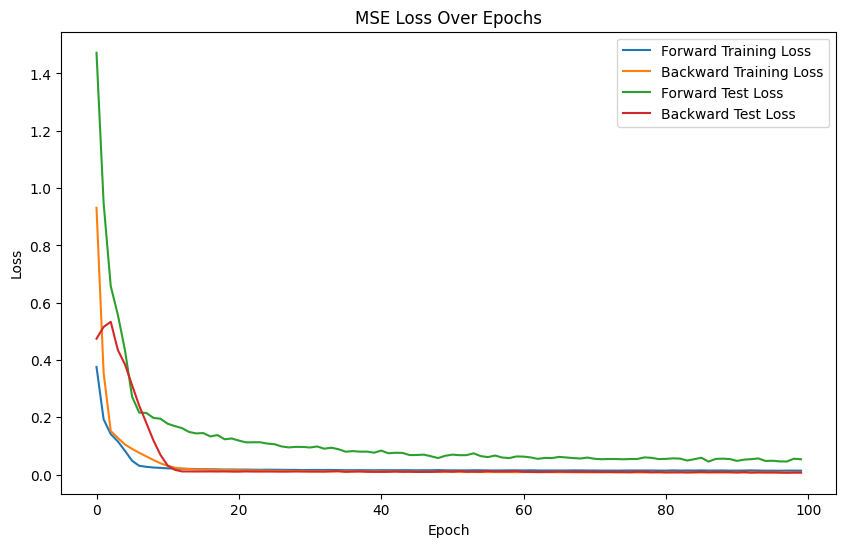

In [53]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("Running on GPU")
else: print("Running on CPU")

# Forward Model Initialization and Training 
model = SimpleRNN(input_size=6, hidden_size=20, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

loss_values_fwd_train, loss_values_fwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=model,
    train_loader=train_loader_fwd,
    test_loader=test_loader_fwd
              )

# Backward Model Initialization and Training
model = SimpleRNN(input_size=6, hidden_size=20, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

loss_values_bkwd_train, loss_values_bkwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=model,
    train_loader=train_loader_bkwd,
    test_loader=test_loader_bkwd
              )

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Loss Over Epochs')
plt.legend()
plt.show()

### Thoughts
So I have run this forward and backward at a number of different forecasting intervals (1 day, 1 week, 1 month, and 90 days). Although as I increase the distance of prediction the Loss does seem to increase, going forward and backward don't seem to indicate any difference in convergence rates. 

## Transformer

In [40]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_size, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.encoder = nn.Linear(input_size, input_size)  # Assuming input is already a feature vector
        self.pos_encoder = PositionalEncoding(input_size, dropout)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, 
                                       dim_feedforward=nhid, dropout=dropout),
            num_layers=nlayers)
        self.decoder = nn.Linear(input_size, 1)  # Output is a single value
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.encoder.bias.data.zero_()
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.encoder(src)  # Ensure input is properly sized
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])  # Decode the last output of the sequence
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


In [41]:
# Parameters for the model
input_size = 6  # same as seq_length
nhead = 2
nhid = 64
nlayers = 2
dropout = 0.2

model = TransformerModel(input_size, nhead, nhid, nlayers, dropout).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


/Users/chrisguarino/opt/anaconda3/envs/predictpast/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, test_loader, num_epochs=10):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Lists to store loss values for plotting
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store train loss for this epoch
        
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                val_loss = criterion(outputs.squeeze(), targets)
                total_test_loss += val_loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)  # Store test loss for this epoch

        print(f'Epoch [{epoch + 1}/{num_epochs}]: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses  # Return the loss lists for plotting


In [43]:
def reset_weights(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

Epoch [1/100]: Train Loss: 0.6891, Test Loss: 2.5072
Epoch [2/100]: Train Loss: 0.4963, Test Loss: 2.5208
Epoch [3/100]: Train Loss: 0.4120, Test Loss: 2.3645
Epoch [4/100]: Train Loss: 0.3596, Test Loss: 1.8366
Epoch [5/100]: Train Loss: 0.3010, Test Loss: 1.5871
Epoch [6/100]: Train Loss: 0.2841, Test Loss: 1.5177
Epoch [7/100]: Train Loss: 0.2465, Test Loss: 1.4581
Epoch [8/100]: Train Loss: 0.2468, Test Loss: 1.4064
Epoch [9/100]: Train Loss: 0.2170, Test Loss: 1.3264
Epoch [10/100]: Train Loss: 0.2175, Test Loss: 1.3145
Epoch [11/100]: Train Loss: 0.2152, Test Loss: 1.2648
Epoch [12/100]: Train Loss: 0.2050, Test Loss: 1.2673
Epoch [13/100]: Train Loss: 0.2022, Test Loss: 1.2259
Epoch [14/100]: Train Loss: 0.1935, Test Loss: 1.2100
Epoch [15/100]: Train Loss: 0.1967, Test Loss: 1.2033
Epoch [16/100]: Train Loss: 0.1767, Test Loss: 1.2089
Epoch [17/100]: Train Loss: 0.1949, Test Loss: 1.1780
Epoch [18/100]: Train Loss: 0.1763, Test Loss: 1.2216
Epoch [19/100]: Train Loss: 0.1677, T

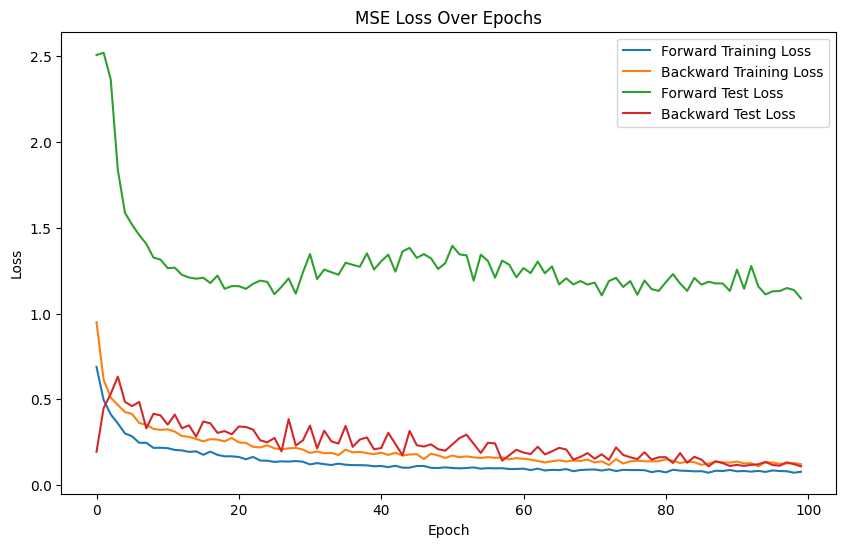

In [45]:
import matplotlib.pyplot as plt

# Assuming train_model has been called and returned loss values for both forward and backward training
model.apply(reset_weights)  # Reset model weights
loss_values_fwd_train, loss_values_fwd_test = train_model(model, train_loader_fwd, test_loader_fwd, num_epochs=100)
model.apply(reset_weights)  # Reset model weights
loss_values_bkwd_train, loss_values_bkwd_test = train_model(model, train_loader_bkwd, test_loader_bkwd, num_epochs=100)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Loss Over Epochs')
plt.legend()
plt.show()
